In [2]:
#import all the libraries I need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge,LinearRegression
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate

In [3]:
#This is a class to feed the TfidfVectorizer with
class LemmaTokenizer(object):
    def __init__(self): 
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, documents): 
        lemmas = [] 
        for t in word_tokenize(documents):
            t = t.strip() 
            lemma = self.lemmatizer.lemmatize(t) 
            lemmas.append(lemma) 
        return lemmas

In [4]:
#Reading data
df=pd.read_csv("dev.tsv",sep="\t")
eval_set=pd.read_csv("eval.tsv",sep="\t")
y=df["quality"]

In [5]:
#In this istance, country was set to "US-France"
df["country"][13050]="US"

c:\users\valerio zingarelli\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


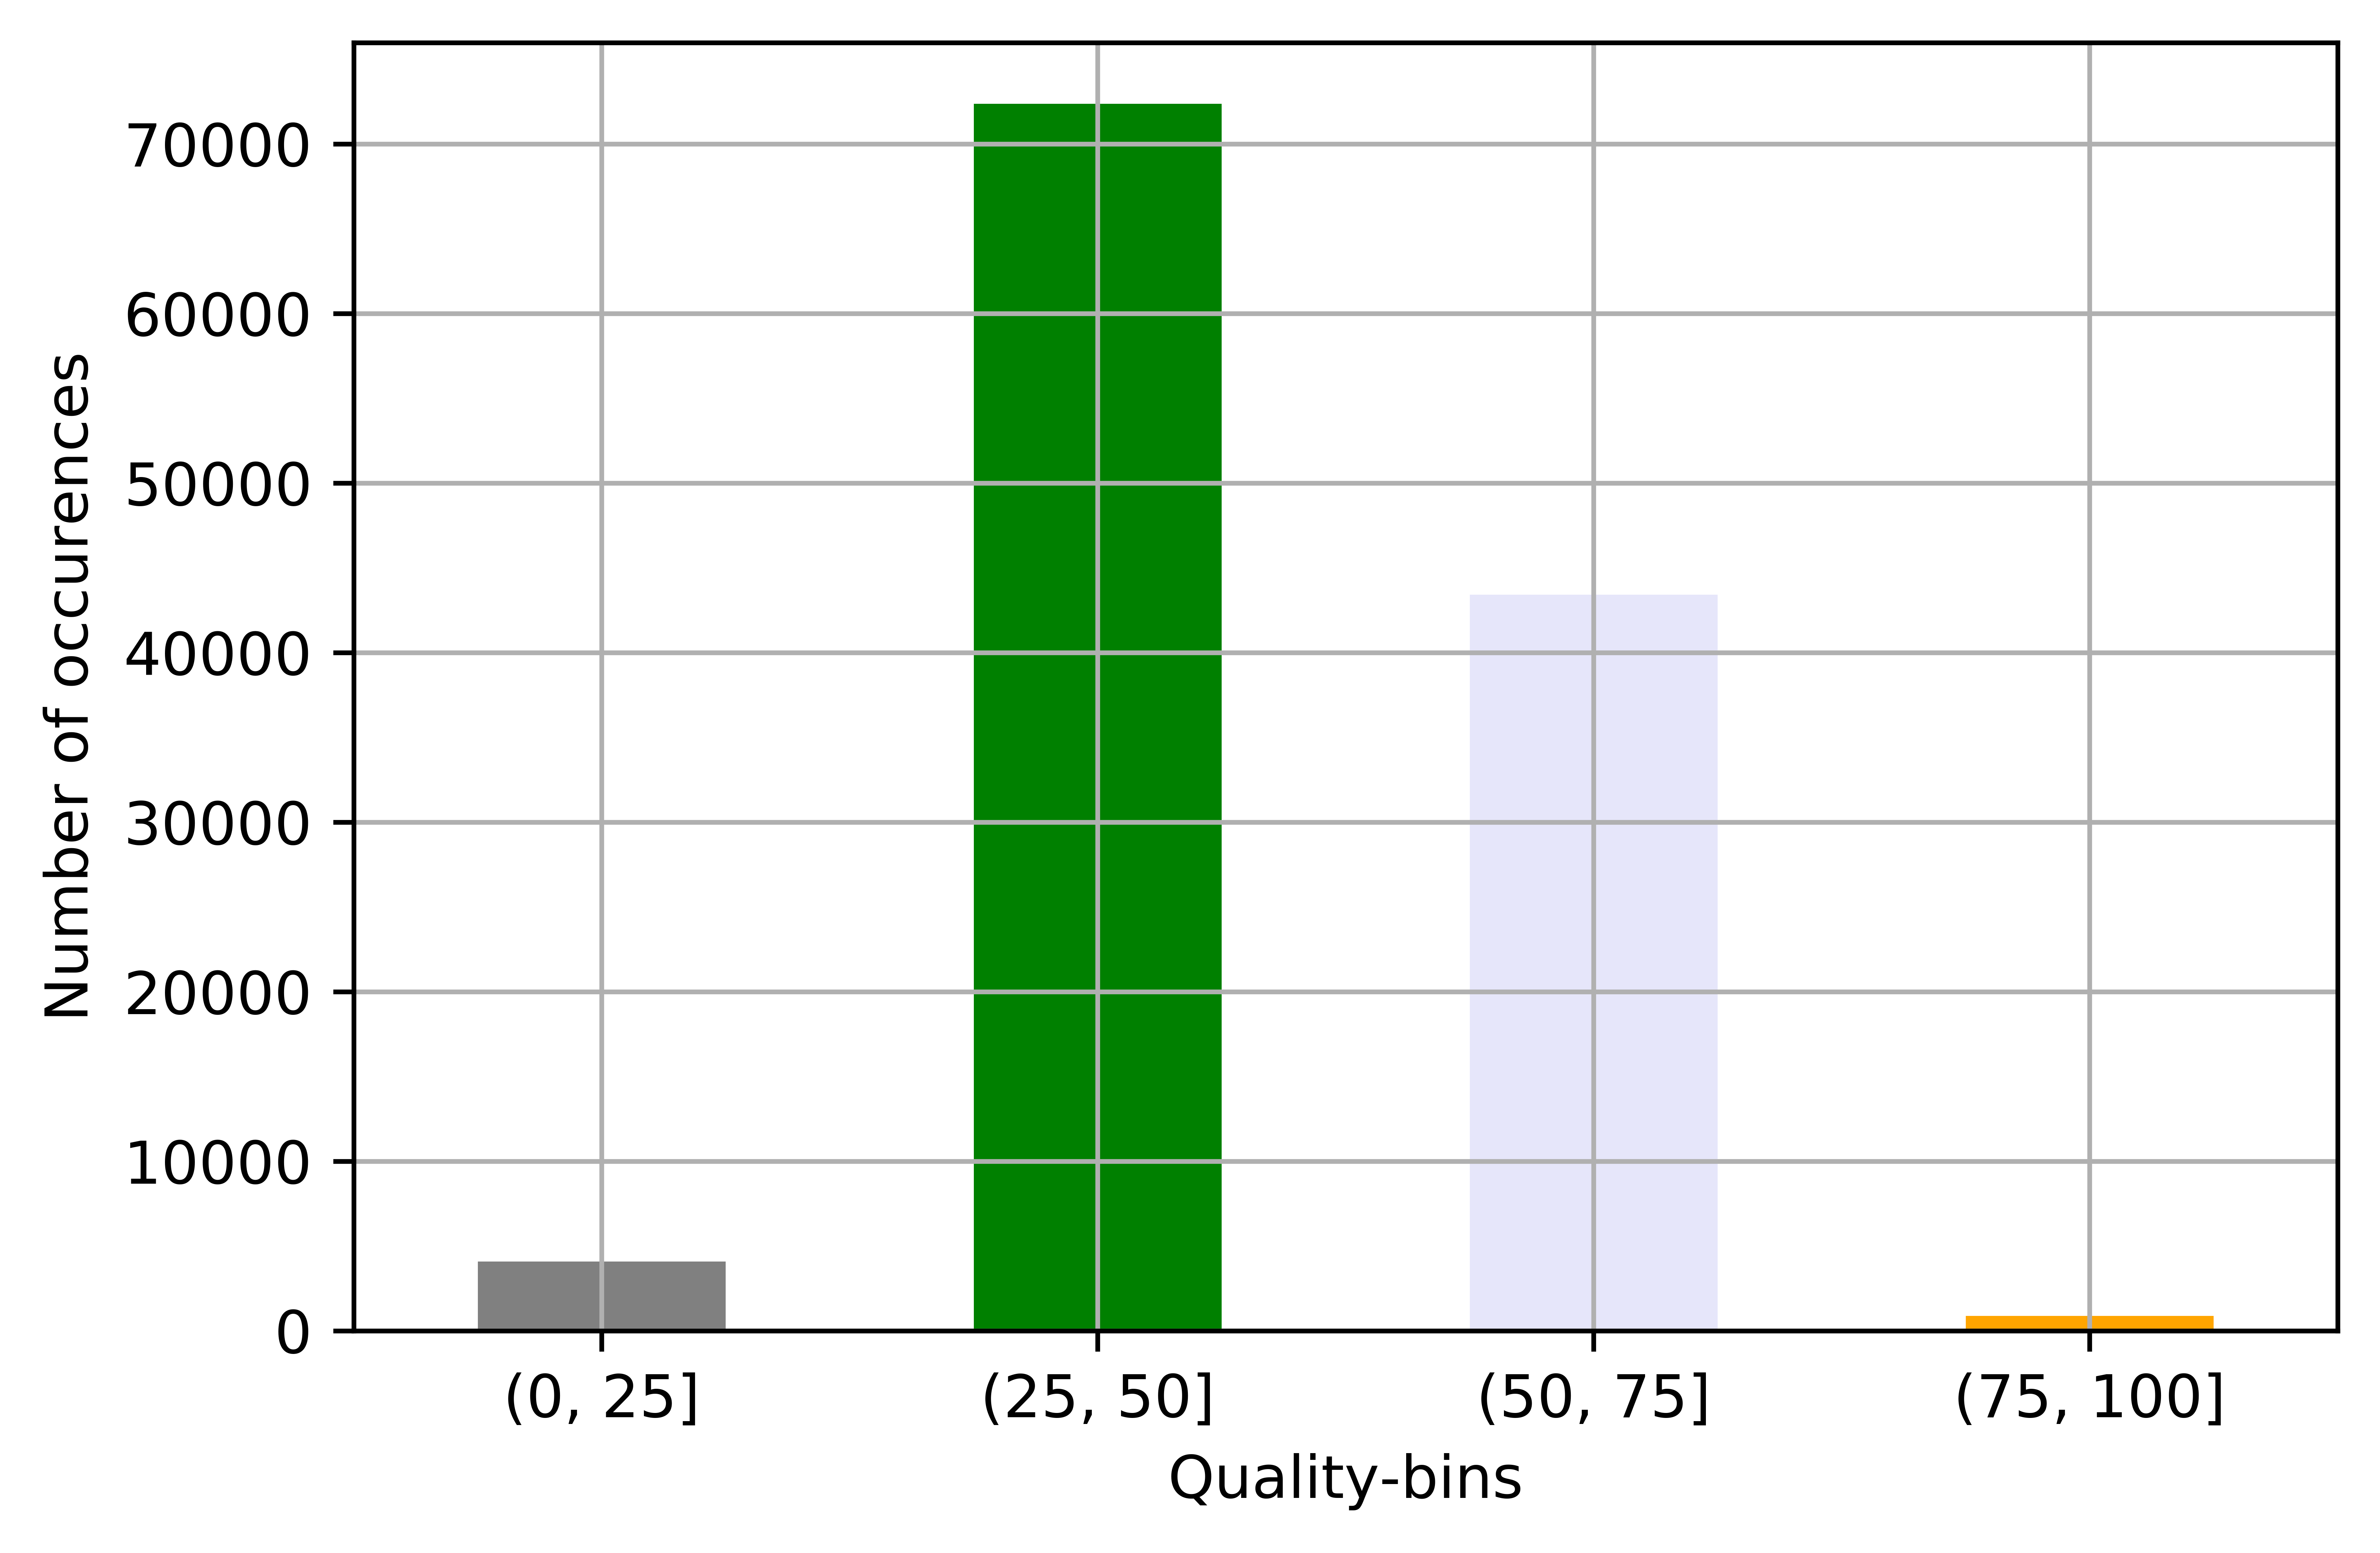

In [6]:
#Data visualization, quality distribution
plt.figure(dpi=1200)
bars = pd.cut(df["quality"], bins=[0, 25, 50, 75,100])
ax = bars.value_counts(sort=False).plot.bar(rot=0,color=['grey', 'green', 'lavender',"orange"])
plt.grid()
plt.xlabel("Quality-bins")
plt.ylabel("Number of occurences")
plt.savefig('quality-distribution.eps', format='eps',dpi=1200)
plt.show()

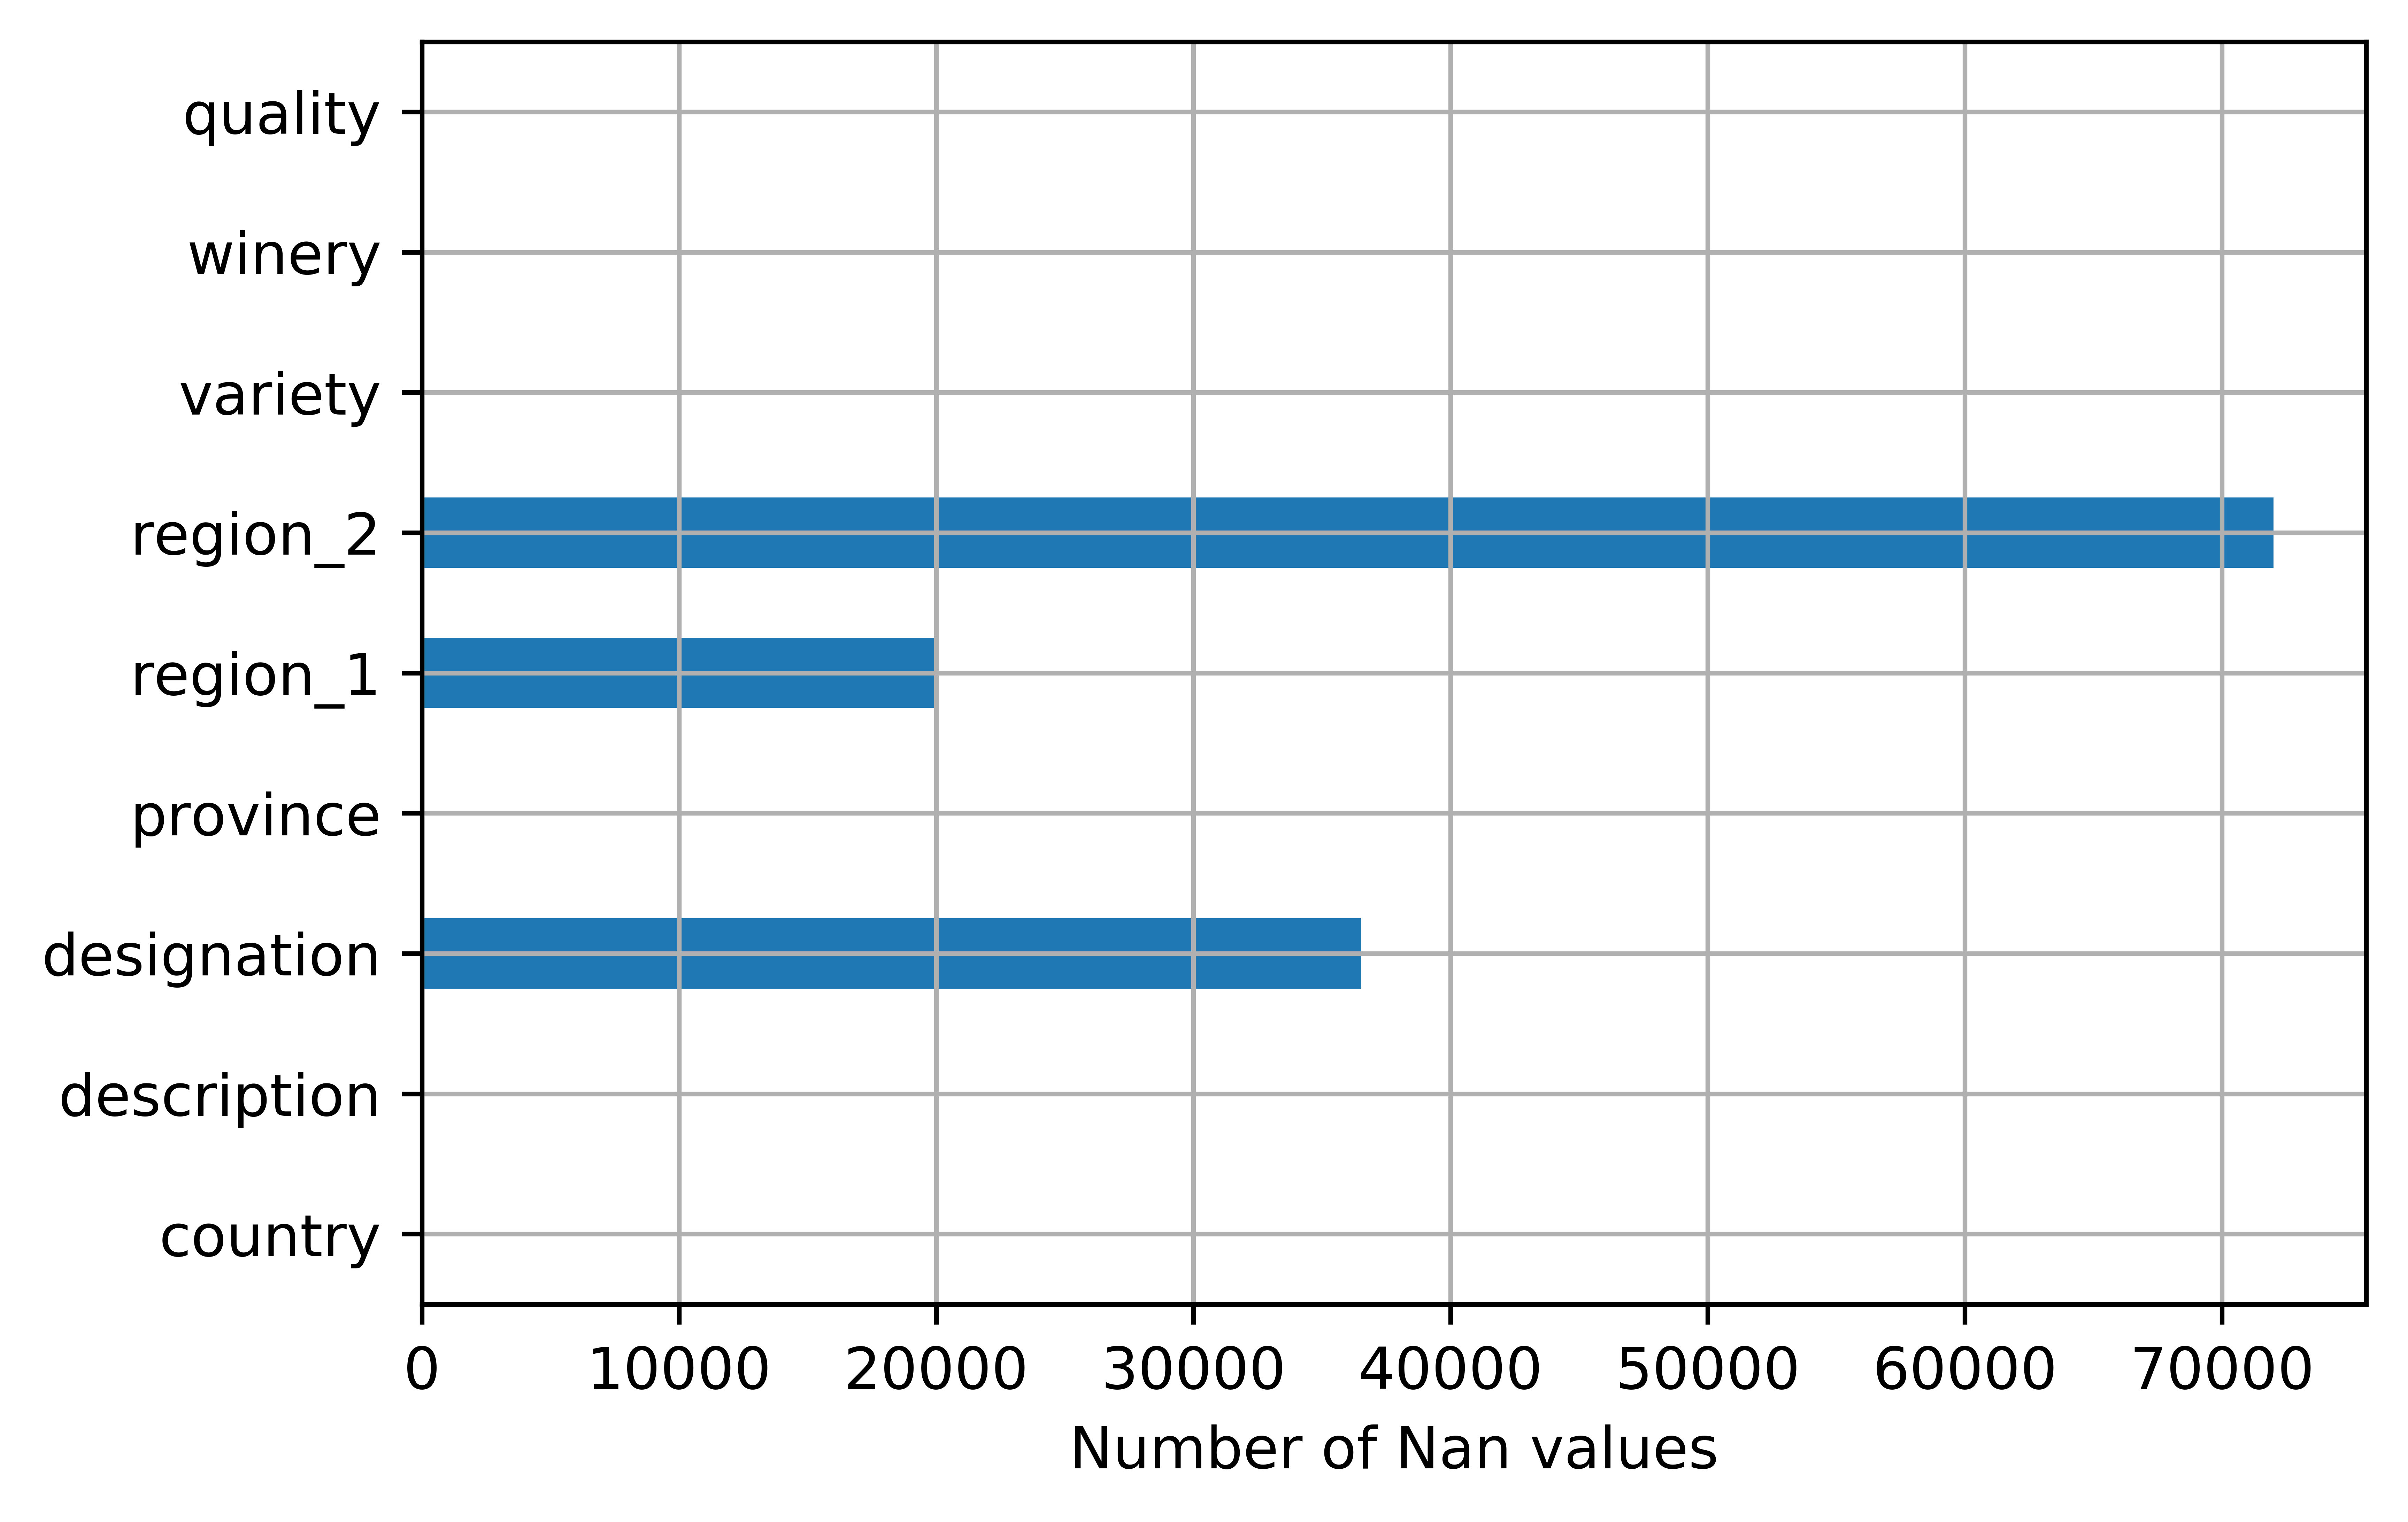

In [7]:
#Data Visualization, NaN distribution
plt.figure(dpi=1200)
plt.tight_layout()
df.isnull().sum().plot(kind='barh')
plt.grid()
plt.xlabel("Number of Nan values")
plt.savefig("Nan-count_horizontal.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [7]:
#Data Exploration, duplicates
print(df.duplicated().sum())
print(eval_set.duplicated().sum())

35716
2595


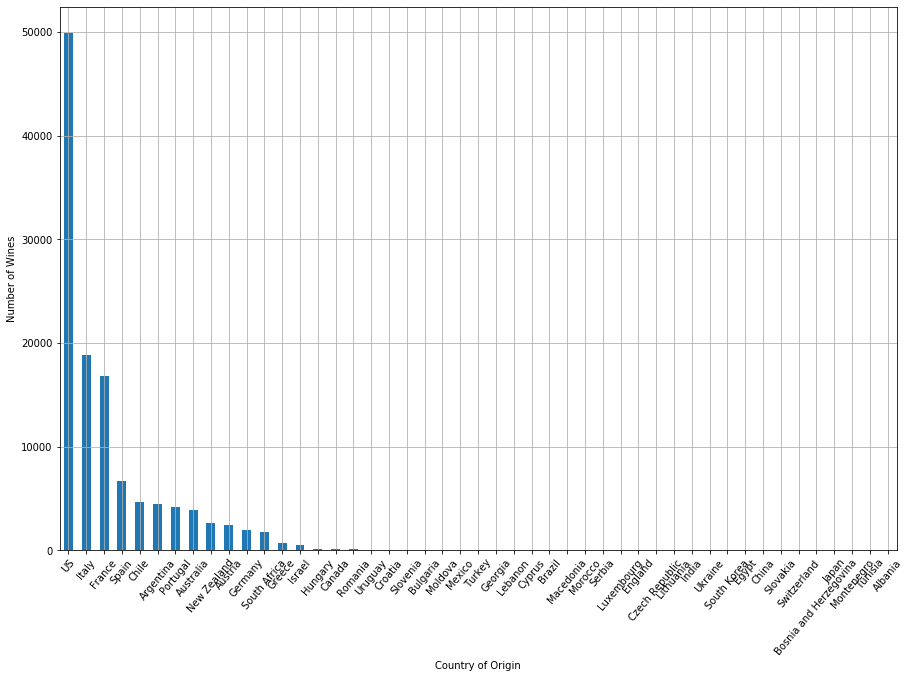

In [8]:
#Data Exploration, how many wines there are for each country?
plt.figure(figsize=(15,10))
df.groupby("country").size().sort_values(ascending=False).plot.bar()
plt.grid()
plt.xticks(rotation=50)
plt.xlabel("Country of Origin")
plt.ylabel("Number of Wines")
plt.savefig("Number of wines.pdf",format="pdf")
plt.show()

In [9]:
#Data exploration, quantity means quality?
from matplotlib import colors
plt.figure(figsize=(15,10),dpi=1200)
plt.grid()
df.groupby("country").mean().sort_values(by="quality",ascending=False)["quality"].plot.bar(color="navy")
plt.grid()
plt.xticks(rotation=50)

plt.xlabel("Country")
plt.ylabel("Average quality of Wines")
plt.savefig("Quality for country.pdf",format="pdf")
plt.show()


In [6]:
#I fill NaN values with the string "Unknown"+ the column

categorical=["country","designation","province","region_1","region_2","variety","winery"]
for category in categorical:
    eval_set[category].fillna("Unknown"+"_"+category,inplace=True)
    df[category].fillna("Unknown"+"_"+category,inplace=True)

In [7]:
#I concatenate dev_set and eval_set to avoid dimensions mismatch problems with
#OneHotEncoding
df_to_encode=pd.concat([df,eval_set])

In [8]:
#I perform a One-Hot Encoding on the categorical attributes of the DataFrame
encoder=OneHotEncoder()
encoder.fit(np.asarray(df_to_encode["country"]).reshape(-1,1))
countries=encoder.transform(np.asarray(df["country"]).reshape(-1,1))
countries_eval=encoder.transform(np.asarray(eval_set["country"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["designation"]).reshape(-1,1))
designations=encoder.transform(np.asarray(df["designation"]).reshape(-1,1))
designations_eval=encoder.transform(np.asarray(eval_set["designation"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["province"]).reshape(-1,1))
provinces=encoder.transform(np.asarray(df["province"]).reshape(-1,1))
provinces_eval=encoder.transform(np.asarray(eval_set["province"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["region_1"]).reshape(-1,1))
region1=encoder.transform(np.asarray(df["region_1"]).reshape(-1,1))
region1_eval=encoder.transform(np.asarray(eval_set["region_1"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["region_2"]).reshape(-1,1))
region2=encoder.transform(np.asarray(df["region_2"]).reshape(-1,1))
region2_eval=encoder.transform(np.asarray(eval_set["region_2"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["variety"]).reshape(-1,1))
varieties=encoder.transform(np.asarray(df["variety"]).reshape(-1,1))
variety_eval=encoder.transform(np.asarray(eval_set["variety"]).reshape(-1,1))
encoder.fit(np.asarray(df_to_encode["winery"]).reshape(-1,1))
wineries=encoder.transform(np.asarray(df["winery"]).reshape(-1,1))
winery_eval=encoder.transform(np.asarray(eval_set["winery"]).reshape(-1,1))

In [9]:
#I apply Tfidf to "description" column in order to extract features from it
lemmaTokenizer = LemmaTokenizer() 
#I use english default stopwords and I add some other words
stopwords=sw.words('english')+['``',"'d", "'ll", "'re", "'s",'r',"'",'v',"'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']+['abov', 'ani', 'becaus', 'befor', 'dure', 'onc', 'onli', 'ourselv', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv']+['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer,stop_words=stopwords,ngram_range=(1,3))
descriptions=vectorizer.fit_transform(df["description"])

In [28]:
bin1=[]
bin2=[]
bin3=[]
bin4=[]
for quality,description in zip(df["quality"],df["description"]):
    if quality <=25:
        bin1.append(description)
    if quality<=50 and quality>25:
        bin2.append(description)
    if quality>50 and quality<=75:
        bin3.append(description)
    if quality<=100 and quality>75:
        bin4.append(description)
bin1=" ".join(description for description in bin1)
bin2=" ".join(description for description in bin2)
bin3=" ".join(description for description in bin3)
bin4=" ".join(description for description in bin4)
wordcloud_bin1=WordCloud(background_color="white",stopwords=stopwords+["wine","flavor","aroma","flavors","palate","aromas"],width=1920,height=1080).generate(bin1)
wordcloud_bin2=WordCloud(background_color="white",stopwords=stopwords+["wine","flavor","aroma","flavors","palate","aromas"],width=1920,height=1080).generate(bin2)
wordcloud_bin3=WordCloud(background_color="white",stopwords=stopwords+["wine","flavor","aroma","flavors","palate","aromas"],width=1920,height=1080).generate(bin3)
wordcloud_bin4=WordCloud(background_color="white",stopwords=stopwords+["wine","flavor","aroma","flavors","palate","aromas"],width=1920,height=1080).generate(bin4)

In [1]:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_bin1)
plt.savefig("wordcloud_worst.pdf")
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_bin2)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_bin3)
plt.show()
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_bin4)
plt.savefig("wordcloud_best.pdf")
plt.show()

NameError: name 'plt' is not defined

In [10]:
#I join all the encodings and Tfidf using sparse matrices to avoid
#speed problems
from scipy.sparse import hstack
X=hstack((countries,descriptions,designations,provinces,region1,region2,varieties,wineries))

In [11]:
#I split my data into train and test 
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2)

In [16]:
#Regressor
param_grid = {
"alpha": [0.1,0.01,0.2],
"tol" : [1e-5,1e-8]
}
LR_params={
    "fit_intercept":[True,False],
    "normalize":[True,False]
}
gs = GridSearchCV(Ridge(), param_grid, scoring="r2", n_jobs=-1,cv=5)
#gs = GridSearchCV(LinearRegression(), LR_params, scoring="r2", n_jobs=-1,cv=5)
gs.fit(X_train, y_train)
gs.best_score_

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=1e-05)

In [51]:
gs.best_estimator_

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=1e-05)

In [18]:
r2_score(y_test,gs.predict(X_test))

0.8679576973391414

In [40]:
#I do the same for eval "description" feature
descriptions_eval=vectorizer.transform(eval_set["description"])

In [41]:
#I join tfidf and one-hot encoding using scipy sparse matrices for speed and space reasons
X_res=hstack((countries_eval,descriptions_eval,designations_eval,provinces_eval,region1_eval,region2_eval,variety_eval,winery_eval))

In [42]:
#I fit my model with all X and y data and I predict the eval_set
gs.fit(X,y)
res=gs.predict(X_res)

fit ended


In [43]:
with open('result.csv', 'w') as file:
    file.write('Id,Predicted\n')
    for i in range(len(res)):
        file.write(f"{i},{res[i]}\n")